In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import QuickProcess_real
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tces=pd.DataFrame.from_csv('tces_with_starpars.csv')

/net/fs/users/hosborn/TESS2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [4]:
tces.shape

(7562, 32)

In [60]:
ixs=[]
for ix in tces.index.values:
    if ix in ixs:
        ix0=ix
        stillinix=True
        while stillinix is True:
            slt=ix0.split('_')
            ix0=slt[0]+'_'+str(int(slt[1])+1).zfill(2)+'_'+slt[2]
            if ix0 not in ixs:
                stillinix=False
                ixs+=[ix0]
    else:
        ixs+=[ix]

In [63]:
tces=tces.set_index(np.array(ixs))
tces['n_det']=np.array([int(ix0.split('_')[1]) for ix0 in tces.index.values])

In [71]:
tces.to_csv('tces_with_starpars_fixed_ix.csv')

In [56]:
ix='000031945773_01_99'
ix in ixs

True

In [57]:
slt=ix.split('_')

In [59]:
slt[0]+'_'+str(int(slt[1])+1).zfill(2)+'_'+slt[2]

'000031945773_02_99'

In [70]:
len(np.unique(tces.index.values))/len(tces.index.values)

1

In [49]:
ixs[6492+417]

'000031945773_01_99'

In [54]:
ixs[6491]

'000031945773_01_99'

In [41]:
row

('MAXMES', 000355544723_00_01       51.151360
 000355544723_01_01       38.592518
 000355544723_02_01       27.750763
 000349518800_00_01       18.058908
 000279955276_00_01       57.402370
 000279955276_01_01       16.067692
 000279955276_02_01        9.824936
 000038573641_00_01       10.072781
 000355509914_00_01        7.868073
 000177353450_00_01       13.125686
 000441357796_00_01     9985.966797
 000441357796_01_01    57195.871094
 000441357796_02_01     1325.924561
 000441357796_03_01       96.969673
 000270038761_00_01       13.490114
 000270038761_01_01        7.656202
 000149473467_00_01       25.179783
 000029842113_00_01       32.964577
 000358457398_00_01       79.898033
 000358457398_01_01       25.600790
 000052368076_00_01       12.678470
 000052368076_01_01        9.967475
 000350443140_00_01        9.444699
 000167692429_00_01      392.101318
 000167692429_01_01      134.309006
 000121421968_00_01        7.334597
 000147271811_00_01        7.774374
 000147271811_01_0

In [67]:
tess_data_dir='/home/hosborn/TESS/fdldata/RealData/'
simrun='TSOP-301-4-sector-run'
out_data_dir='/home/hosborn/TESS/Processed_RealDat_2'
nglob=1001
nloc=101
ndurs=5
cut_anoms=True
dospline=False
use_dv=True

nrow=0
for rowid,tce_row in tces.iterrows():        
    out_fname=rowid
    if not os.path.exists(os.path.join(out_data_dir,out_fname+'_info.npy')):
        # Get filenames

        sects=tce_row['sectors'].replace('[','').replace(']','').split(' ')
        sector_prefixes = QuickProcess_real.TESS_TSOP301_DV_SECTOR_PREFIXES
        if len(sects)==1:
            prefix=sector_prefixes[int(sects[0])]
            dvstring=os.path.join(tess_data_dir, simrun, 'sector-' + str(sects[0]),'exports','dv-time-series',prefix[0]+str(int(tce_row['TID'])).zfill(16)+prefix[1])
        else:
            if '3' in sects:
                prefix=sector_prefixes[13]
            else:
                prefix=sector_prefixes[12]
            dvstring=os.path.join(tess_data_dir, simrun, 'sector-99','exports','dv-time-series',prefix[0]+str(int(tce_row['TID'])).zfill(16)+prefix[1])
        if not os.path.exists(dvstring):
            print("DV lc "+dvstring+" doesn't exist. Downloading.")
            os.system("curl -C - -L -o "+dvstring+" https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/"+dvstring.split('/')[-1])
            if not os.path.exists(dvstring):
                if '-s0001-s0003-' in dvstring:
                    dvstring=dvstring.replace('-s0001-s0003-','-s0001-s0002-').replace('-00129','-00111')
                    if os.path.isfile(dvstring):
                        filenames=[dvstring]
                    else:
                        os.system("curl -C - -L -o "+dvstring+" https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/"+dvstring.split('/')[-1])
                elif '-s0001-s0002-' in dvstring:
                    dvstring=dvstring.replace('-s0001-s0002-','-s0001-s0003-').replace('-00111','-00129')
                    if os.path.isfile(dvstring):
                        filenames=[dvstring]
                    else:
                        os.system("curl -C - -L -o "+dvstring+" https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/"+dvstring.split('/')[-1])
        filenames = [dvstring]

        #Using more raw lightcurves
        sector_prefixes = QuickProcess_real.TESS_TSOP301_SECTOR_PREFIXES
        suffixes={1:'-0120-s_lc.fits',2:'-0121-s_lc.fits',3:'-0123-s_lc.fits',4:'-0124-s_lc.fits'}
        if len(sects)==1:
            sectors=[int(sects[0])]
        elif '3' in sects:
            sectors=[1,2,3]
        else:
            sectors=[1,2]
        for sector in sectors:
            sector_prefix = sector_prefixes[sector]
            tic_id = "%.16d" % int(tce_row['TID'])
            prefix = "tess" + sector_prefix + "-s000" + str(sector) + "-"
            filename = os.path.join(tess_data_dir, simrun, 'sector-' + str(sector),'exports', 'light-curve', prefix + tic_id + suffixes[sector])
            if os.path.isfile(filename):
                filenames.append(filename)
            else:
                print("Cannot find \"",filename,"\".   Attemping download")
                os.system("curl -C - -L -o /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-"+str(sector)+"/exports/light-curve/"+filename.split('/')[-1]+" https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/"+filename.split('/')[-1])
                if os.path.isfile(filename):
                    print("successful")
                    filenames.append(filename)
                else:
                    print("failed")
        dur=tce_row['TDUR']/24.0
        all_time, all_flux, all_centroid, valid_indices, dv_data = QuickProcess_real.read_tess_light_curve(filenames, use_dv=use_dv, tce=tce_row)
        #spline
        if dospline:
            #print('post-read.  flux',all_flux,'cent', all_centroid)
            time, flux, centroid=QuickProcess_real.process_light_curve(all_time, all_flux, all_centroid, QUICK_SPLINE=True,only_cent=use_dv)
            centroid=-1*centroid
            #print('post-spline.  flux',flux,'cent',centroid)
        else:
            time, flux = all_time, all_flux
            all_centroid=np.array(all_centroid)
            #Getting "radius"
            centroid = np.sqrt(all_centroid.T[0]**2 + all_centroid.T[1]**2 )

        #Normalising flux and centroid to zero:
        flux/=np.nanmedian(flux)
        flux-=np.nanmedian(flux)
        centroid-=np.nanmedian(centroid)
        #print('post-norm. flux',flux,'cent',centroid)

        #If number of durations the "local" view covers is more than a full period, setting to one period
        if ndurs*dur>tce_row['TPERIOD']:
            ndurs=tce_row['TPERIOD']/dur

        #try:

        #folding
        fold_time, fold_flux, fold_centroid = QuickProcess_real.phase_fold_and_sort_light_curve(time, flux, centroid, tce_row['TPERIOD'], tce_row['TEPOCH'],cut_anoms=cut_anoms)

        #print('post-fold. flux',fold_flux,'cent',fold_centroid)

        #Doing local view binning, and using this to get normalisation constant:
        locs=QuickProcess_real.MedianBin(fold_time,fold_flux,fold_centroid,None,
                       -0.5*ndurs*dur,
                       0.5*ndurs*dur,
                       nloc,'loc')

        #print('post-bin. flux',locs[:,0],'cent',locs[:,1])

        depth_norm=abs(np.nanmedian(locs[int(np.ceil((0.5*nloc)*((ndurs-0.33)/ndurs))):int(np.floor((0.5*nloc)*((ndurs+0.33)/ndurs))),0]))

        #Doing global view binning
        globs=QuickProcess_real.MedianBin(fold_time,fold_flux,fold_centroid,None,
                        -0.5*tce_row['TPERIOD'],0.5*tce_row['TPERIOD'],
                        nglob,'glob')
        #Normalising to average depth
        locs[:,0]/=depth_norm
        globs[:,0]/=depth_norm

        #Finding RMs of (normalised) global lightcurve, to act as scaling vector for centroids
        rms_norm=QuickProcess_real.transitfree_std(globs[0])
        globstd=QuickProcess_real.transitfree_std(globs[:,1])
        locs[:,1]*=rms_norm/globstd#QuickProcess_real.transitfree_std(locs[:,1],'loc',ndurs)
        globs[:,1]*=rms_norm/globstd

        np.save(os.path.join(out_data_dir,out_fname+'_loc.npy'),locs)
        np.save(os.path.join(out_data_dir,out_fname+'_glob.npy'),globs)

        fold_time[fold_time<0]+=tce_row['TPERIOD']
        #As data is -0.5Per -> 0.5Per, need to shift time to
        locs_sec=QuickProcess_real.MedianBin(np.where(fold_time<0,fold_time+tce_row['TPERIOD'],fold_time),
                           fold_flux,fold_centroid,[depth_norm,rms_norm],
                           0.5*tce_row['TPERIOD']-0.5*ndurs*dur,
                           0.5*tce_row['TPERIOD']+0.5*ndurs*dur,
                           nloc,'loc',ndurs)

        np.save(os.path.join(out_data_dir,out_fname+'_sec.npy'),locs_sec)

        fold_time_p2, fold_flux_p2, fold_centroid_p2 = QuickProcess_real.phase_fold_and_sort_light_curve(time, flux, centroid, tce_row['TPERIOD']*2, tce_row['TEPOCH'],cut_anoms=cut_anoms)

        p2locs_odd=QuickProcess_real.MedianBin(fold_time_p2,fold_flux_p2,fold_centroid_p2,[depth_norm,rms_norm],
                             -0.5*ndurs*dur,
                             0.5*ndurs*dur,
                             nloc,'loc',ndurs)
        p2locs_even=QuickProcess_real.MedianBin(np.where(fold_time_p2<0,fold_time_p2+2*tce_row['TPERIOD'],fold_time_p2),
                              fold_flux_p2,fold_centroid_p2,[depth_norm,rms_norm],
                              tce_row['TPERIOD']-0.5*ndurs*dur,
                              tce_row['TPERIOD']+0.5*ndurs*dur,
                              nloc,'loc',ndurs)
        bothp2s=np.column_stack((p2locs_odd,p2locs_even))
        np.save(os.path.join(out_data_dir,out_fname+'_odd_even.npy'),bothp2s)

        info=tce_row.values.ravel()

        pickle.dump(dv_data,open(os.path.join(out_data_dir,out_fname+'_view_info.pickle'),'wb'))

        np.save(os.path.join(out_data_dir,out_fname+'_info.npy'),info)
        print('X - ',os.path.join(out_data_dir,out_fname))
        #except:
        #    print("FAILED TO PROCESS")
    else:
        print('already processed',out_fname)
    nrow+=1


('already processed', '000355544723_00_01')
('already processed', '000355544723_01_01')


QuickProcess_real.py:169: RuntimeWarning: divide by zero encountered in log10
  dv_data['SESMES_LOG_RATIO']=np.log10((dv_data['MAXSES']*np.sqrt(dv_data['NTRANS']))/(dv_data['MAXMES']))
QuickProcess_real.py:372: RuntimeWarning: invalid value encountered in divide
  nonaninf=(time/time==1.0)*(flux/flux==1.0)*CutAnomDiff(flux)


('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355544723_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349518800_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279955276_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279955276_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279955276_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038573641_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355509914_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177353450_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441357796_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441357796_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441357796_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441357796_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000270038761_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000270038761_01_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441357671_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299899924_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299899924_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441432509_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000097431593_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000269793346_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214912528_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214912528_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167344043_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092350801_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201292296_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177309964_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177309964_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000394357918_00_01')
('X - ', '/home/hosb

QuickProcess_real.py:966: RuntimeWarning: divide by zero encountered in double_scalars
  


('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000179040607_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206498138_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000269857486_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231708319_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231708319_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139188326_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070440470_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139841210_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139841210_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139841210_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139841210_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000290077397_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308451526_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000270166263_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038396965_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140940493_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140940493_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279614617_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279614617_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000388131924_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150098860_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232063593_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232063593_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232063593_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232063593_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232063593_04_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000303909865_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000303909865_01_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000273792220_04_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000273792220_05_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441398770_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441398770_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441398770_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441398770_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441398770_04_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029717216_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000290496318_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000215054743_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000215054743_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000215054743_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219140650_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219140650_01_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000262958558_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000262958558_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000262958558_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913675_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913675_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382528174_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000404768019_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000052079677_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000052079677_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000307031724_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167007869_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206462125_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206462125_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260162387_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266998480_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266998480_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055404385_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055404385_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000179637387_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000289828268_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220523550_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000309299238_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000309299238_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913775_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913775_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913775_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214913775_03_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000419669917_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220482527_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000269793839_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032200310_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032200310_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038586438_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038586438_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271900514_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000261560580_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441422527_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441422527_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149248196_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149248196_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149248196_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149248196_03_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092629854_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000280052690_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000301980639_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306829961_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000143855290_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000126700850_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000289917522_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234334772_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234334772_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220478846_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220478846_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000381857817_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000381857817_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029984014_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038820496_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038820496_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038820496_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220432563_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000290131778_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871376_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871376_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871376_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441432457_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355703913_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000147339266_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092873799_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092873799_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231702397_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000364588501_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201293780_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201293780_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029344935_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141334293_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000212324438_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000235037761_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000381979279_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000211413277_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000053812109_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000290045451_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000039018680_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000311925584_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000287328866_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219335256_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219335256_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000267263253_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350445771_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000232064182_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000358467237_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231631020_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000270034306_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055524055_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055524055_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029543294_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029543294_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234290432_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234290432_01_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000261656371_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150101472_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150101472_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000212254842_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000269772516_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000269772516_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370324073_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139067693_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000302298212_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382422098_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234523599_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000290076869_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281461138_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441380191_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000025078924_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000025078924_02_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000238170857_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152926069_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152926069_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152250936_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152250936_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000289916363_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000289916363_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000126602778_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000126602778_01_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000033878971_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277683130_00_01')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000326445217_00_01')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000089502706_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000089502706_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441051650_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000262530407_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231058925_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231058925_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370010296_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070744265_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304735_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304735_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306773798_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300013489_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339633702_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339633702_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150187916_03_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197886566_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000322063810_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150101472_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000287773752_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000287773752_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300015238_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382425148_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382425148_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279251861_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000066412342_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000240764987_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000238027971_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234523599_00_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070785920_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000155989956_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231061733_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231061733_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231061733_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201255204_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000030317301_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000301866976_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149018345_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149018345_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000077031296_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000158623531_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259885176_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259885176_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000255745149_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000434105094_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167574667_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000401840741_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000229810745_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000229810745_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000069911347_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000069911347_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000069911347_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000214664426_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055652785_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055652785_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000144386393_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000144386393_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031998499_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000012393800_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032150630_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032150630_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000396697136_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000396697136_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049687260_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279569718_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279569718_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300290824_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259901389_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_02_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_03_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_04_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_05_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000158536052_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055659311_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000120585579_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000120585579_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000262609754_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355635441_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000373918302_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000471016669_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000471016669_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000273792220_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349835367_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350618622_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197934692_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000391887390_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055758485_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000100103200_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000114851071_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000076989773_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141526439_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055272119_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055272119_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000415969184_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000415969184_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000415969184_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150357290_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000183230834_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000183230834_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201898220_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070775324_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070775324_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000120607386_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092966_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092966_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092966_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092966_03_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279955276_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279955276_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355509914_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000309659126_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049783554_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049783554_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049783554_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000051912829_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000051912829_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167086201_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000008964552_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281728276_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281728276_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279510954_00_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177309964_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177309964_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339607421_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339607421_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070744273_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000070744273_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176872955_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000102069549_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350027679_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350027679_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350027679_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350027679_03_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871545_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871545_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031850842_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031850842_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031850842_02_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000077031414_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000229143092_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000005634158_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281573523_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281573523_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000183596242_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000183596242_01_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038573584_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150359500_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000166808151_00_02')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000166808151_01_02')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000248382514_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038696105_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055652785_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055652785_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299901449_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207205231_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207205231_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220478846_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000146636926_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000398571094_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220433363_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349790953_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339668420_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092960_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219373406_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220433364_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000257691369_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000257691369_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000166835568_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000166835568_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000248348545_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000248348545_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000098658304_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000098658304_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000142206468_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000142206468_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349832824_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349832824_01_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207174531_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207174531_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266769521_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000037764281_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055384162_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055384162_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339633702_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300013489_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000165941377_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350954272_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350954272_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350954272_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219223683_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000307158170_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000164720673_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197884260_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000091642216_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049558810_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049558810_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000049558810_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000408012968_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000408012968_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000313937090_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000313937090_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000313937090_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000066412342_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000311410850_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000040047579_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000471015740_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000244163413_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000244163413_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219239945_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032000625_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032000625_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000423749203_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350743714_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220474209_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220474209_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278683641_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278683641_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152589104_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000035664974_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220539110_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000040061078_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000040061078_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041865879_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041865879_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000272431317_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000272431317_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000241393039_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000241393039_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152360540_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000344370217_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000344370217_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000037744932_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000179040607_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177387380_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266770712_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266770712_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000266770712_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000248346844_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167695122_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167695122_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000248355362_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029919288_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000179639066_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000309702975_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000146712645_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029939923_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149346418_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167656297_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293166952_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382528174_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382528174_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092993104_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092993104_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092993104_02_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197908268_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281979481_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167007869_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000072705933_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000199733788_00_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000199733788_01_03')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281979330_00_03')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000343813659_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207200487_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207200487_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055404385_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000179637387_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000401872377_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141183901_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000318966048_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219222703_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000250386181_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150357290_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000089256802_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000089256802_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000044743153_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000044678751_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000009858404_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000250409756_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000035744707_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000035744707_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000439901136_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000387400570_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370236000_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370236000_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370236000_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370236000_03_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000328162247_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350618622_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000066573768_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308991822_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308991822_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308991822_03_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150145456_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150145456_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000404927661_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000404927661_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000092346866_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000009845586_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038396965_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038396965_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000401889161_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150098860_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000064071894_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308744455_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140576174_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140692280_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308307606_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308307606_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350431335_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260609205_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219239945_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000274039489_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000121134517_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000121134517_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000347552724_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000347552724_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000170676440_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149347480_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000323295967_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000323295967_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000302458773_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000035856187_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149473467_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149473467_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000251078096_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000251078096_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167692429_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167692429_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000387586260_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000387586260_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219362976_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349480507_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349480507_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206468815_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206468815_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000004742129_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000004742129_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000004742129_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000198076334_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308451529_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000406450972_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000170749770_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141807839_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141807839_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141807839_02_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699825_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699825_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000408130762_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000029960110_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000036728203_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308537791_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308537791_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041533313_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000088338809_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382043650_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000261376909_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000261376909_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308851582_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000308851582_01_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000009843991_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000009843991_02_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000441512315_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000170698265_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000170698265_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000152562646_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259675295_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259675295_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000373918302_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000198011271_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350479101_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167303776_02_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260304296_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176841424_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031998499_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000030317282_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279569718_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279569718_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000257525627_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000257525627_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000153077621_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000328429515_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038824355_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041484615_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206385626_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000146688260_00_04')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278683844_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041226614_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231809798_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231809798_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150100106_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150100106_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382517745_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382517745_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197933923_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197933923_01_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000159951311_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031528507_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231293332_00_04')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231293332_01_04')
('X - ', '/home/hosb

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220473309_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000220473309-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220473309_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000167697655-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167697655_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141212720_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141212720_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278824614_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382259748_00_99')
('X - ', '/home/hosborn/TESS/Processe

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370008372_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370115640_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207200487-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207200487_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207200487-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207200487_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207200487-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207200487_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/0003009

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000369706249_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000201898220-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000201898220-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201898220_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000277103955-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277103955_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000271892453-00111_dvt.fits doesn't exist. Downloading.
('Cannot find

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220471131_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000220471131-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220471131_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000220471131-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220471131_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260502102_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260502102_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260502102_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000025155310_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000206609630_00_99')
('X - ', '/home/hosborn/TESS/Processe

QuickProcess_real.py:238: RuntimeWarning: divide by zero encountered in log10
  dv_data['PRAD_LOG_RATIO']=np.log10(tce['PRADIUS']/13)


('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207085748_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207085748-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207085748_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207085748-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207085748_02_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207085748-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000207085748_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000391894459_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/0003918

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234512399_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234512399_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_07_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_08_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237915523_09_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382259748_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382259748_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382259748_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038699658_03_99')
('X - ', '/home/hosb

/net/fs/users/hosborn/TESS2/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in divide
/net/fs/users/hosborn/TESS2/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in divide
/net/fs/users/hosborn/TESS2/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in divide
/net/fs/users/hosborn/TESS2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1426: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
QuickProcess_real.py:964: RuntimeWarning: divide by zero encountered in divide
  elif viewtype=='glob':


('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055497281_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055497281_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055497281_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141712167_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000231020638-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231020638_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304218_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304218_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304218_07_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304218_08_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167304218_09_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234505400_00_99')
('X - ', '/home/hosborn/TESS/Pro

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382258517_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000382258517-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382258517_02_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000382258517-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382258517_03_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000142148228-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000142148228-0121-s_lc.fits', '".   Attemping download')
failed
('

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141770299_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141770299_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871545_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300871545_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150360766_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150360766_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177349901_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000201898222-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201898222_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038602307_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000038602307_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176872955_00_99')
('X - ', '/home/hosborn/TESS/Pro

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041259805_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041259805_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234510995_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141622065_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176934407_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176934407_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231828370_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231828370_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231828370_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000025118964_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237866103_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237866103_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382069441_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382069441_01_99')
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425997655_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000348998165_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000393490554-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000393490554_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000176955267_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141708335_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382256692_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293268667_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293268667_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000207176480-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealD

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167344196_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167344196_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031105740_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000277099925-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277099925_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000277099925-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277099925_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231833061_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231833061_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231744905_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealD

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281541555_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000279741942-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279741942_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000471015740_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000471015740_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000280803800_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425997655_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425997655_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425997655_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425997655_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000257719469_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220474209_03_99')
('X - ', '/home/hosborn/TESS/Pro

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000100029948_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000100029948-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000100029948_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299940359_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299940359_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000299940359_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150030205_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167339584_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167339584_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350862394_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150098860_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/l

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231742782_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000231742782-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231742782_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306826966_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279161423_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000372849630_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300244770_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300244770_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300244770_06_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000220565276-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processe

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000309659126_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167754523_01_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000177353450-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177353450_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141413932_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000349518800-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349518800_00_99')
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000349518800-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000233967143_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000293224065-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293224065_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000293224065-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293224065_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000293224065-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000293224065_02_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000293224065-00111_dv

('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000229147927-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000229147927_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000370234343-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000370234343-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000370234343_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000370234343-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/expo

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000040514802_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000040514802-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000040514802_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300293197_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300293197_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300293197_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278863150_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278863150_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149988523_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149988523_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149988523_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149988523_03_99')
('X - ', '/home/hosborn/TESS/Processed_Real

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349152387_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141772259_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000364588832-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000364588832_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237914496_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032068898_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000198076334-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-000000

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031796253_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000031796253-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031796253_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000348897766-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000348897766-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000348897766_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000348897766-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosbor

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149120276_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000149120276-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000149120276-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149120276_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300971133_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300971133_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000220402290-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-00000002204

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271554516_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000271554516-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271554516_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141624979_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271891181_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260301896_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000279251861-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000279251861-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279251861_00_99')
DV lc /h

('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000197829751-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000197829751_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260640910_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000177354239-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177354239_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055298910_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055298910_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055298910_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055298910_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000166969516_02_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-se

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231810586_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000231810586-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000231810586-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231810586_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000231810586-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000231810586-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231810586_02_99')
('X - ', '/ho

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306669607_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294754396_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294754396_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000350520993-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350520993_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041533313_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000041533313_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201255204_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220456828_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000207199350-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277300045_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000350345393-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000350345393-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350345393_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167008987_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000150249728-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000150249728_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-00000003893655

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140687826_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000140687826-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140687826_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000231058925-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000231058925-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000231058925_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000231058925-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosbor

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000358110060_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237914496_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141772259_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300382665_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300382665_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300382665_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349375972_05_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000055745925-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055745925_00_99')
('X - ', '/home/hosborn/TESS/Processed_Real

('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000350479101-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350479101_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000350479101-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000350479101-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350479101_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000350479101-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/expo

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000220517198_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000348898049_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000373844472-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000373844472-0121-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000373844472_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000219989191-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000219989191-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260001669_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000260001669_03_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000389672830-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000389672830-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000389672830_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149347629_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000149347629_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000166835568-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/s

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000388179896_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000388179896-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000388179896-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000388179896_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000358459933-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000358459933_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141124144_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000355706675_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000350652586_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000201922554-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000201922554-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201922554_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349310205_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349310205_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000404798700-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000404798700_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000277298434_00_99')
('X - ',

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000339576478_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300866996_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000229142860-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000229142860-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000229142860_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000229142860-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000229142860-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosb

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000349972600_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000030317282_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000031998499-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000031998499-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031998499_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141268467_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141268467_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000453099697_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278988794_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000278988794_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000404

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000142086813_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259901124_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000259901124_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140659980_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140659980_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140659980_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000140659980_05_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167549764_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167549764_03_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000031740375-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000031740375_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141096071_02_99')
('X - ', '/home/hosborn/TESS/Processed_Real

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092960_03_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000294092960-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000294092960-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000294092960_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300038935_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000167526476-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000167526476-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/ho

('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000219998026-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219998026_02_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000219998026-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000219998026-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000219998026_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000024704862_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139285666_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000139285666_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sec

('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271900514_03_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000271900514_04_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000281498280_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000279740733_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032150630_06_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032150630_07_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000032150630_08_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177313167_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000177313167_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306740183_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306740183_02_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000306740183_03_99')
DV lc /home/hosborn/

('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000201938311-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000201938311_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000272086677-00111_dvt.fits doesn't exist. Downloading.
('Cannot find "', '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000272086677-0120-s_lc.fits', '".   Attemping download')
failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000272086677_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000055270064_01_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000150431920-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosb

failed
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000237924601_00_99')
DV lc /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000167163980-00111_dvt.fits doesn't exist. Downloading.
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000167163980_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000234549227_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141606958_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000141606958_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425863844_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425863844_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000300379556_01_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000382186170_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425975034_00_99')
('X - ', '/home/hosborn/TESS/Processed_RealDat_2/000425975034_01_99')
('X - ', '/home/hosborn/TESS/Process

In [36]:
list(tces.index.values['000031945773_01_99']

,MAXMES,MAXSES,TDEPTH,TDUR,TEPOCH,TPERIOD,TSNR,n_det,rmsCdpp,sector,...,gallat,gallong,logg,mass,objType,pmDEC,pmRA,ra,rad,rho
000031945773_01_99,10.907307,3.083687,265.725652,2.138546,1325.308394,0.296748,12.967645,1.0,NaN,99.0,...,-41.334085,284.608153,4.33392,0.951024,STAR,17.1343,-18.4326,54.795284,1.09989,0.714733
000031945773_01_99,10.091356,3.477200,190.902204,1.216142,1325.591004,0.296886,11.745942,1.0,NaN,99.0,...,-41.334085,284.608153,4.33392,0.951024,STAR,17.1343,-18.4326,54.795284,1.09989,0.714733


In [68]:
tce_row.index

Index([u'MAXMES', u'MAXSES', u'TDEPTH', u'TDUR', u'TEPOCH', u'TPERIOD',
       u'TSNR', u'n_det', u'rmsCdpp', u'sector', u'sectors', u'is_toi', u'toi',
       u'toi_disp', u'TID', u'ID', u'MH', u'Teff', u'Tmag', u'contratio', u'd',
       u'dec', u'gallat', u'gallong', u'logg', u'mass', u'objType', u'pmDEC',
       u'pmRA', u'ra', u'rad', u'rho'],
      dtype='object')

In [69]:
tces.iloc[0]

MAXMES           51.1514
MAXSES           10.5207
TDEPTH            685944
TDUR                 1.5
TEPOCH           1325.42
TPERIOD         0.463581
TSNR                 NaN
n_det                  0
rmsCdpp              NaN
sector                 1
sectors            [[1]]
is_toi                 0
toi                    0
toi_disp             0.0
TID            355544723
ID           3.55545e+08
MH                   NaN
Teff                7418
Tmag              13.566
contratio            NaN
d                1858.66
dec             -54.0763
gallat          -43.4038
gallong          342.773
logg             4.13705
mass             1.69558
objType             STAR
pmDEC          -0.505195
pmRA             1.55336
ra               320.361
rad              1.84225
rho              0.27119
Name: 000355544723_00_01, dtype: object

In [32]:
tce_row['TEPOCH']

1325.3207718778585

In [22]:
filenames

['/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000149059954-00111_dvt.fits',
 '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000149059954-0120-s_lc.fits',
 '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-2/exports/light-curve/tess2018234235059-s0002-0000000149059954-0121-s_lc.fits']

In [29]:
from astropy.io import fits
hdu=fits.open( '/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-1/exports/light-curve/tess2018206045859-s0001-0000000149059954-0120-s_lc.fits')

IOError: Empty or corrupt FITS file

In [28]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2018-10-06'         / file creation date.                            
TSTART  =    1354.101978098092 / observation start time in TJD                  
TSTOP   =    1381.514471377755 / observation stop time in TJD                   
DATE-OBS= '2018-08-23T14:25:

In [11]:
'TUNIT5' in hdu[1].header

True

In [17]:
tce_row

MAXMES           7.38006
MAXSES           6.17211
TDEPTH             27867
TDUR             6.81714
TEPOCH           1335.51
TPERIOD          29.5207
TSNR             6.01233
n_det                  0
rmsCdpp              NaN
sector                99
sectors        [[0 1 2]]
is_toi                 0
toi                    0
toi_disp             0.0
TID            220576880
ID           2.20577e+08
MH                   NaN
Teff                 NaN
Tmag              16.199
contratio            NaN
d                    NaN
dec             -62.2544
gallat          -47.9912
gallong          279.429
logg                 NaN
mass                 NaN
objType             STAR
pmDEC              57.84
pmRA              391.61
ra               47.8389
rad                  NaN
rho                  NaN
Name: 000220576880_00_99, dtype: object

In [6]:
len(fold_time),len(fold_flux),len(fold_centroid)

(17353, 17353, 17353)

In [47]:
len(time)

18094

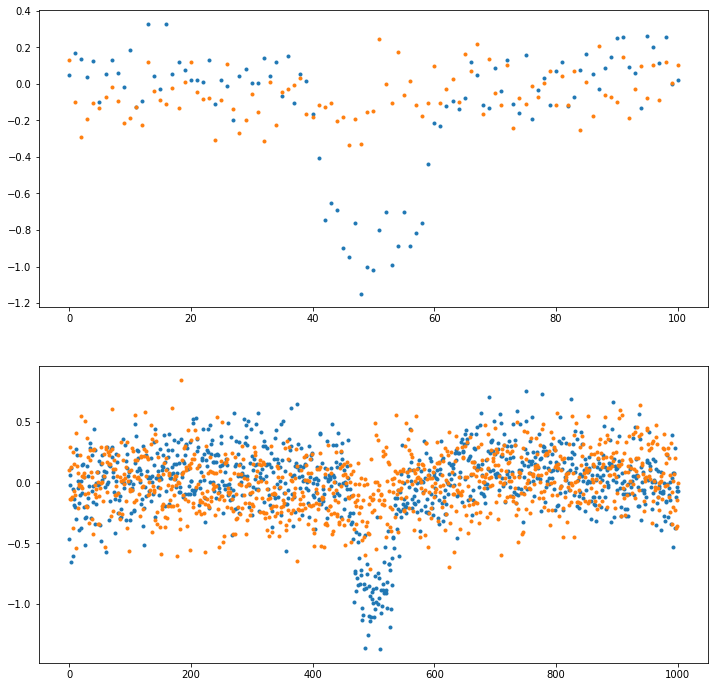

In [43]:
plt.figure(figsize=(12,12))
plt.subplot(211)
loc=np.load(os.path.join(out_data_dir,out_fname+'_loc.npy'))
plt.plot(loc,'.')
plt.subplot(212)
glob=np.load(os.path.join(out_data_dir,out_fname+'_glob.npy'))
plt.plot(glob,'.')

In [5]:
filenames

['/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-99/exports/dv-time-series/tess2018206190142-s0001-s0002-0000000024695725-00111_dvt.fits']

In [104]:
TESS_TSOP301_DV_SECTOR_PREFIXES

{1: ['tess2018206190142-s0001-s0001-', '-00106_dvt.fits'],
 2: ['tess2018235142541-s0002-s0002-', '-00109_dvt.fits'],
 3: ['tess2018267104341-s0003-s0003-', '-00126_dvt.fits'],
 4: ['tess2018292093540-s0004-s0004-', '-00135_dvt.fits'],
 12: ['tess2018206190142-s0001-s0002-', '-00111_dvt.fits'],
 13: ['tess2018206190142-s0001-s0003-', '-00129_dvt.fits']}

In [106]:
tces.iloc[0]

SNR                   -1
TDEPTH           0.64147
TDUR                 0.5
TEPOCH           1325.48
TID          2.46957e+07
TPERIOD          0.23674
maxmes           9.83285
maxses           3.56024
n_det                  0
rmsCdpp           280770
sector                99
sectors          [[1 2]]
is_toi                 0
toi                    0
toi_disp             0.0
ID           2.46957e+07
MH                   NaN
Teff                4813
Tmag              16.013
contratio            NaN
d                    NaN
dec             -67.8909
gallat          -48.5572
gallong          295.923
logg                 NaN
mass                 NaN
objType             STAR
pmDEC            17.5118
pmRA             46.6092
ra               25.2516
rad                  NaN
rho                  NaN
Name: 000024695725_00_99, dtype: object

In [98]:
tces.iterrows()

<generator object iterrows at 0x7f8281436f00>

In [ ]:
tces.

In [ ]:
df=pd.DataFrame()
for sect in [1,2,3,4,99]:
    for ffile in glob.glob('/home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-'+str(sect)+'/exports/dv-time-series/*.fits'):
        try:
            hdu_list=fits.open(ffile)
        except:
            print("Re-downloading file")
            os.system('curl -C - -L -o /home/hosborn/TESS/fdldata/RealData/TSOP-301-4-sector-run/sector-'+str(sect)+'/exports/dv-time-series/'+ffile.split('/')[-1]+' https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/'+ffile.split('/')[-1])
            hdu_list=fits.open(ffile)
        TID=int(hdu[0].header['OBJECT'].split(' ')[1])
        for n in range(len(hdu)-2):
            colnames=['TSNR','TDEPTH','TDUR','TEPOCH','TPERIOD','MAXMES','MAXSES']
            dv_data={c:hdu_list[n+1].header[c] if hdu_list[n+1].header[c] is not fits.card.UNDEFINED else np.nan for c in colnames }
            dv_data['n_det']=n
            dv_data['rmsCdpp']=np.nan
            dv_data['sector']=sect
            nsects=np.round(hdu_list[n+1].header['TELAPSE']/27.0)
            if nsects>1 and hdu_list[n+1].header['TSTOP']>1409:
                dv_data['sectors']='[['+' '.join(np.arange(4-nsects,4).astype(int).astype(str))+']]'
            elif nsects>1 and hdu_list[n+1].header['TSTOP']<1409:
                dv_data['sectors']='[['+' '.join(np.arange(3-nsects,3).astype(int).astype(str))+']]'
            else:
                dv_data['sectors']='[['+str(sect)+']]'
            df=df.append(pd.Series(dv_data,name=str(TID).zfill(12)+'_'+str(int(n)).zfill(2)+'_'+str(sect).zfill(2)))

In [138]:
fits.open(ffile)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f822b616650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f822b555c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f822b567510>]

In [114]:
['SNR', 'TDEPTH', 'TDUR', 'TEPOCH', 'TID', 'TPERIOD', 'maxmes', 'maxses','n_det', 'rmsCdpp', 'sector', 'sectors', 'is_toi', 'toi', 'toi_disp']


In [127]:
nsects=2
np.arange(4-nsects,4)

array([2, 3])

In [133]:
hdu[3].header

IndexError: list index out of range